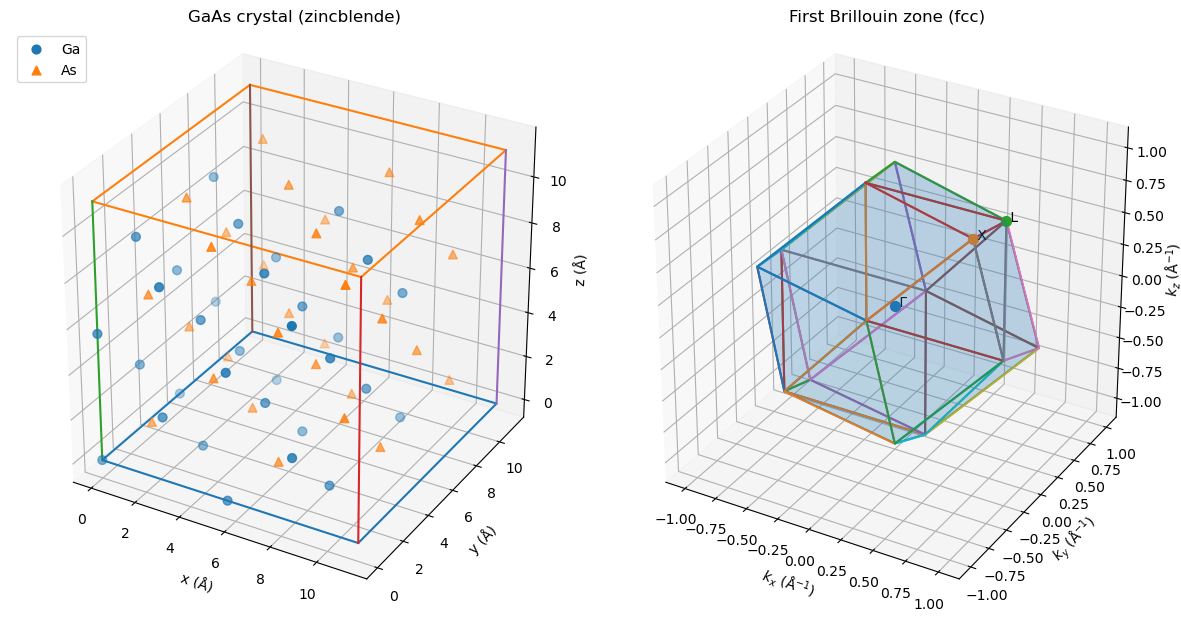

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import HalfspaceIntersection, ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Real-space: GaAs (zincblende) crystal

a = 5.653  # lattice constant of GaAs in Angstrom 

# Conventional face centered cubic cell basis positions
ga_basis = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])
as_basis = np.array([
    [0.25, 0.25, 0.25],
    [0.25, 0.75, 0.75],
    [0.75, 0.25, 0.75],
    [0.75, 0.75, 0.25],
])

# Build a small supercell for visualization
nx, ny, nz = 2, 2, 2
translations = np.array([(i, j, k) for i in range(nx) for j in range(ny) for k in range(nz)], dtype=float)

ga_positions = (ga_basis[None, :, :] + translations[:, None, :]).reshape(-1, 3) * a
as_positions = (as_basis[None, :, :] + translations[:, None, :]).reshape(-1, 3) * a

# Reciprocal-space: First Brillouin zone of fcc
# GaAs is fcc with a 2 atom basis, BZ depends on the Bravais lattice type
# We want to compute the Wigner–Seitz cell of the reciprocal lattice

# Reciprocal primitive vectors for fcc:
factor = 2.0 * np.pi / a
b1 = factor * np.array([0.0, 1.0, 1.0])
b2 = factor * np.array([1.0, 0.0, 1.0])
b3 = factor * np.array([1.0, 1.0, 0.0])

# Generate reciprocal lattice vectors G = h * b1 + k * b2 + l * b3
N = 3
G_list = []
for h in range(-N, N + 1):
    for k in range(-N, N + 1):
        for l in range(-N, N + 1):
            if h == 0 and k == 0 and l == 0:
                continue
            G = h * b1 + k * b2 + l * b3
            G_list.append(G)
G_list = np.array(G_list)

# Keep only the shortest shell of reciprocal lattice vectors, nearest neighbors of the reciprocal lattice for Wigner-Seitz
G_norms = np.linalg.norm(G_list, axis=1)
min_norm = np.min(G_norms)
shell = G_list[G_norms <= (min_norm * 1.01)]  # small tolerance

# Halfspaces for Wigner–Seitz cell:
# For each G, points k in Wigner-Seitz satisfy |k| <= |k - G|  =>  k·G <= |G|^2 / 2
# Convert to form: (Gx, Gy, Gz, d) with G·k + d <= 0  where d = -|G|^2/2
halfspaces = np.hstack([shell, -0.5 * np.sum(shell**2, axis=1)[:, None]])

# The origin is at the ceentre of the Wigner-Seitz cell
interior_point = np.zeros(3)

hs = HalfspaceIntersection(halfspaces, interior_point)
bz_vertices = hs.intersections

# Convex hull to get faces
hull = ConvexHull(bz_vertices)

# Plot: real-space lattice and reciprocal-space BZ side-by-side

fig = plt.figure(figsize=(12, 6))

# Plot in real space
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.scatter(ga_positions[:, 0], ga_positions[:, 1], ga_positions[:, 2], marker="o", s=40, label="Ga")
ax1.scatter(as_positions[:, 0], as_positions[:, 1], as_positions[:, 2], marker="^", s=40, label="As")

# Draw the outer supercell box for context
Lx, Ly, Lz = nx * a, ny * a, nz * a
box = np.array([
    [0, 0, 0],
    [Lx, 0, 0],
    [Lx, Ly, 0],
    [0, Ly, 0],
    [0, 0, 0],
    [0, 0, Lz],
    [Lx, 0, Lz],
    [Lx, Ly, Lz],
    [0, Ly, Lz],
    [0, 0, Lz],
])

# Edges of the plot
ax1.plot(box[:5, 0], box[:5, 1], box[:5, 2])
ax1.plot(box[5:, 0], box[5:, 1], box[5:, 2])
for i in range(4):
    ax1.plot([box[i, 0], box[i + 5, 0]], [box[i, 1], box[i + 5, 1]], [box[i, 2], box[i + 5, 2]])

ax1.set_title("GaAs crystal (zincblende)")
ax1.set_xlabel("x (Å)")
ax1.set_ylabel("y (Å)")
ax1.set_zlabel("z (Å)")
ax1.legend(loc="upper left")
ax1.set_box_aspect((Lx, Ly, Lz))

# Reciprocal-space subplot of first BZ
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

# Plot polyhedron faces using hull
faces = [bz_vertices[simplex] for simplex in hull.simplices]
poly = Poly3DCollection(faces, alpha=0.15)  # transparent faces
ax2.add_collection3d(poly)

# Plot edges of the BZ
for simplex in hull.simplices:
    tri = bz_vertices[simplex]
    tri = np.vstack([tri, tri[0]])
    ax2.plot(tri[:, 0], tri[:, 1], tri[:, 2])

# Label common high symmetry points
Gamma = np.array([0.0, 0.0, 0.0])
X = factor * np.array([0.0, 1.0, 0.0])       
L = factor * np.array([0.5, 0.5, 0.5])        

ax2.scatter([Gamma[0]], [Gamma[1]], [Gamma[2]], s=50, marker="o")
ax2.text(Gamma[0], Gamma[1], Gamma[2], " Γ")
ax2.scatter([X[0]], [X[1]], [X[2]], s=50, marker="o")
ax2.text(X[0], X[1], X[2], " X")
ax2.scatter([L[0]], [L[1]], [L[2]], s=50, marker="o")
ax2.text(L[0], L[1], L[2], " L")

# Label BZ plot
ax2.set_title("First Brillouin zone (fcc)")
ax2.set_xlabel(r"$k_x$ (Å$^{-1}$)")
ax2.set_ylabel(r"$k_y$ (Å$^{-1}$)")
ax2.set_zlabel(r"$k_z$ (Å$^{-1}$)")

# Symmetric bounds around BZ
max_extent = np.max(np.abs(bz_vertices))
ax2.set_xlim(-max_extent, max_extent)
ax2.set_ylim(-max_extent, max_extent)
ax2.set_zlim(-max_extent, max_extent)
ax2.set_box_aspect((1, 1, 1))

plt.tight_layout()
plt.show()
